In [11]:
import os 
from datasets import Dataset
import pandas as pd

from mistral_inference.transformer import Transformer
from mistral_inference.generate import generate

from mistral_common.tokens.tokenizers.mistral import MistralTokenizer
from mistral_common.protocol.instruct.messages import UserMessage
from mistral_common.protocol.instruct.request import ChatCompletionRequest

In [ ]:
dataset = Dataset.from_pandas(pd.read_csv("./Comments.csv"))

In [13]:
dataset

Dataset({
    features: ['body', 'communityName', 'createdAt', 'numberOfreplies', 'upVotes'],
    num_rows: 22132
})

In [26]:


prompt_q1 = """Analyze the sentiment of the following comment and classify it as Positive, Neutral, or Negative.""" + str(sample['body']) + "date: " + str(sample['createdAt']) + "upvotes: " +str(sample['upVotes']) + """Response format:
                     [Positive/Neutral/Negative]"""

def map_function(sample):
        
    user_prompt = """You are analyzing Reddit comments to identify self-reported changes in opioid use and harm reduction behaviors. A policy change occurred on January 31, 2023. For the following comment, determine if:
                        1. The user reports any opioid use (e.g., mentions frequency, amount, or cessation).
                        2. The user describes harm reduction behaviors (e.g., naloxone use, clean syringes, or seeking help).
                        3. There are any noticeable changes in these behaviors compared to before the policy change (if applicable).
                        Comment: """ + str(sample['body']) + "date: " + str(sample['createdAt']) + """ Respond with:
                        - "Opioid Use": [Yes/No/Not clear].
                        - "Harm Reduction": [Yes/No/Not clear].
                        """

    # chat completion request
    completion_request = ChatCompletionRequest(messages=[UserMessage(content=user_prompt)])
    # encode message
    tokens = mistral_tokenizer.encode_chat_completion(completion_request).tokens

    # generate results
    out_tokens, _ = generate([tokens], model, max_tokens=128, temperature=0.0, eos_id=mistral_tokenizer.instruct_tokenizer.tokenizer.eos_id)
    # decode generated tokens
    result = mistral_tokenizer.instruct_tokenizer.tokenizer.decode(out_tokens[0])

    sample['sentiment'] = result
    
    return sample

In [15]:
# load tokenizer
mistral_tokenizer = MistralTokenizer.from_file(os.path.expanduser("~")+"/Opioid_NLP/mistral_models/7B-Instruct-v0.3/tokenizer.model.v3")

# load model
model = Transformer.from_folder(os.path.expanduser("~")+"/Opioid_NLP/mistral_models/7B-Instruct-v0.3")

In [27]:
map_function(dataset[1006])

{'body': 'Harm reduction without also putting health care options in place is a half measure that seems designed to fail.',
 'communityName': 'r/britishcolumbia',
 'createdAt': '2024-04-24T03:22:43.000Z',
 'numberOfreplies': 1.0,
 'upVotes': '25',
 'sentiment': '- "Opioid Use": Not clear.\n- "Harm Reduction": Not clear.\n- "Change Observed": Not clear. The comment does not provide specific details about opioid use or harm reduction behaviors, nor does it mention any changes compared to before the policy change.'}

In [ ]:
dataset_mapped = dataset.map(map_function)

In [25]:
dataset_mapped.save_to_disk("./dataset_mapped_sentiment")

Saving the dataset (0/1 shards):   0%|          | 0/22132 [00:00<?, ? examples/s]

In [3]:
from datasets import load_from_disk

In [4]:
dataset_mapped = load_from_disk("./dataset_mapped")

In [4]:
dataset_mapped[10]

{'body': 'Decriminalization ≠ legalization.\n\n\n\n\nWhat an absolute lying sack of shit.\xa0',
 'communityName': 'r/onguardforthee',
 'createdAt': '2024-05-27T15:59:01.000Z',
 'numberOfreplies': 4.0,
 'upVotes': '562',
 'writing': '- "Opioid Use": Not clear. The comment does not mention any details about opioid use, frequency, amount, or cessation.\n- "Harm Reduction": Not clear. The comment does not describe any harm reduction behaviors such as naloxone use, clean syringes, or seeking help.\n- "Change Observed": Not clear. The comment does not provide any information about changes in opioid use or harm reduction behaviors before or after the policy change on January 31, 2023.'}

In [ ]:
import re
from collections import defaultdict


def classify_segment(segment):
    segment = segment.lower()
    
    # Check if it matches opioid use, harm reduction, or change observed
    if 'opioid use' in segment:
        return 'opioid use'
    elif 'harm reduction' in segment:
        return 'harm reduction'
    else:
        return 'not clear'


def classify_clarity(segment):
    segment = segment.lower()
    
    if 'not clear' in segment:
        return 'not clear'
    elif 'no' in segment:
        return 'no'
    elif 'yes' in segment:
        return 'yes'
    else:
        return 'not clear'

# Function to process each comment and add the classification to the comment
def process_comments(comment):
    writing = comment['writing']
    
    segments = writing.split('- ')
    clarity = []
    segs = ['opioid_use', 'harm_reduction']
    i = 0

    for segment in segments[1:]:
        comment[str(segs[i])] = classify_clarity(segment)
        i += 1
        if i == 3: 
            break

    if i < 3:
        for i in range(i, 3):
            comment[str(segs[i])] = "not clear"
            

    return comment


processed_comments = dataset_mapped.map(process_comments)

Map:   0%|          | 0/22132 [00:00<?, ? examples/s]

In [25]:
processed_comments[1000]

{'body': "Our courts won't prosecute straight possession charges sooo, arresting them when they can't lay charges would be extremely silly.",
 'communityName': 'r/canada',
 'createdAt': '2024-04-27T00:05:52.000Z',
 'numberOfreplies': 2.0,
 'upVotes': '25',
 'writing': '- "Opioid Use": Yes. The user implies that opioids are being possessed, but no specific details about the frequency, amount, or cessation of use are provided.\n- "Harm Reduction": No. The user does not mention any harm reduction behaviors in this comment.\n- "Change Observed": Not clear. The user does not provide any information about changes in opioid use or harm reduction behaviors before or after the policy change on January 31, 2023.',
 'opioid_use': 'no',
 'harm_reduction': 'no',
 'change_observed': 'not clear'}

In [21]:
df = processed_comments.to_pandas()

In [23]:
df['createdAt'] = pd.to_datetime(df['createdAt'])

df['month'] = df['createdAt'].dt.month
df['year'] = df['createdAt'].dt.year


year_filter = df['year'] == 2023 
month_filter = df['month'].isin([1])  
opioid_filter = df['opioid_use'].isin(['yes'])


filtered_df = df[year_filter & month_filter & opioid_filter]

In [79]:
count_opioid_use = {2023: [], 2024: []}
count_harm_use = {2023: [], 2024: []}
count_change_use = {2023: [], 2024: []}

In [ ]:
for i in (2023, 2024):
    for j in range(1, 13):
        year_filter = df['year'] == i 
        month_filter = df['month'].isin([j])  
        
        opioid_filter_yes = df['opioid_use'].isin(['yes'])
        opioid_filter_no = df['opioid_use'].isin(['no'])
        opioid_filter_not = df['opioid_use'].isin(['not clear'])

        harm_filter_yes = df['harm_reduction'].isin(['yes'])
        harm_filter_no = df['harm_reduction'].isin(['no'])
        harm_filter_not = df['harm_reduction'].isin(['not clear'])

        num_total = df[year_filter & month_filter].shape[0]
        if num_total == 0:
            num_total = 1

        filtered_df_yes = df[year_filter & month_filter & opioid_filter_yes].shape[0]/ num_total
        filtered_df_no = df[year_filter & month_filter & opioid_filter_no].shape[0]/ num_total
        filtered_df_not = df[year_filter & month_filter & opioid_filter_not].shape[0]/ num_total

        filtered_df_yes1 = df[year_filter & month_filter & harm_filter_yes].shape[0] / num_total
        filtered_df_no1 = df[year_filter & month_filter & harm_filter_no].shape[0]/ num_total
        filtered_df_not1 = df[year_filter & month_filter & harm_filter_not].shape[0]/ num_total

        
        count_opioid_use[i].append((filtered_df_yes, filtered_df_no, filtered_df_not))
        count_harm_use[i].append((filtered_df_yes1, filtered_df_no1, filtered_df_not1))

In [81]:
count_opioid_use

{2023: [(0.2222222222222222, 0.18518518518518517, 0.5925925925925926),
  (0.22666666666666666, 0.17777777777777778, 0.5955555555555555),
  (0.09345794392523364, 0.24299065420560748, 0.6635514018691588),
  (1.0, 0.0, 0.0),
  (0.35714285714285715, 0.0, 0.6428571428571429),
  (0.36796536796536794, 0.15584415584415584, 0.47619047619047616),
  (0.2283464566929134, 0.12598425196850394, 0.6456692913385826),
  (0.18300248138957817, 0.19478908188585609, 0.6222084367245657),
  (0.17339667458432304, 0.171021377672209, 0.6555819477434679),
  (0.1661600810536981, 0.19858156028368795, 0.6352583586626139),
  (0.0, 0.0, 0.0),
  (0.15632458233890215, 0.16945107398568018, 0.6742243436754176)],
 2024: [(0.2515177797051171, 0.17432784041630528, 0.5741543798785776),
  (0.0, 0.0, 0.0),
  (0.1425959780621572, 0.13893967093235832, 0.7184643510054844),
  (0.1888494528246081, 0.19136350192250814, 0.6197870452528838),
  (0.1672473867595819, 0.16492450638792103, 0.667828106852497),
  (0.1673758865248227, 0.148936

# Sentiment Analysis

In [15]:
from datasets import load_from_disk

dataset_mapped = load_from_disk("./dataset_mapped_sentiment")

In [16]:
dataset_mapped

Dataset({
    features: ['body', 'communityName', 'createdAt', 'numberOfreplies', 'upVotes', 'sentiment'],
    num_rows: 22132
})

In [18]:
import pandas as pd

df = dataset_mapped.to_pandas()

df["date"] = pd.to_datetime(df["createdAt"])

# Extract Year-Month
df["year_month"] = df["date"].dt.to_period("M")

/tmp/ipykernel_2702516/2406287478.py:8: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df["year_month"] = df["date"].dt.to_period("M")


In [19]:
# Define a function to map sentiments
def map_sentiment(sentiment):
    sentiment = str(sentiment).lower()  # Ensure lowercase
    if "positive" in sentiment:
        return 1
    elif "negative" in sentiment:
        return -1
    elif "neutral" in sentiment:
        return 0
    else:
        return 0

# Apply mapping
df["sentiment"] = df["sentiment"].apply(map_sentiment)

In [20]:
df["sentiment"].value_counts()

sentiment
-1    12873
 0     6421
 1     2838
Name: count, dtype: int64

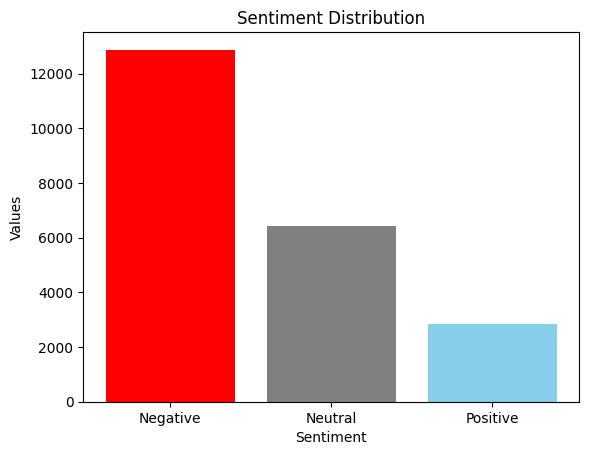

In [21]:
import matplotlib.pyplot as plt

# Sample data
categories = ['Negative', 'Neutral', 'Positive']
values = [12873, 6421, 2838]

# Create bar plot
plt.bar(categories, values, color=["red", "grey", 'skyblue'])

# Add labels and title
plt.xlabel('Sentiment')
plt.ylabel('Values')
plt.title('Sentiment Distribution')

# Show plot
plt.show()


<Figure size 1200x600 with 0 Axes>

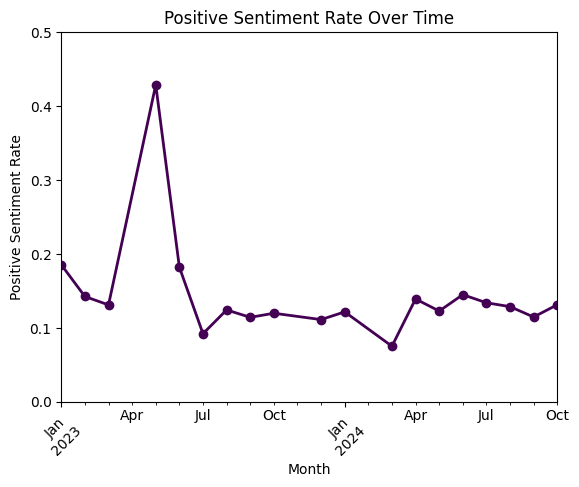

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns


category_to_keep = 1  

df_filtered = df[df["sentiment"] == category_to_keep]

sentiment_counts = df_filtered.groupby(["year_month", "sentiment"]).size().unstack()
sentiment_counts_s = df.groupby(["year_month", "sentiment"]).size().unstack()

total_category = sentiment_counts.sum(axis=1)
total_comments = sentiment_counts_s.sum(axis=1)

# Filter months with enough comments
valid_months = total_category[total_comments >= threshold].index
filtered_sentiment_counts = sentiment_counts.loc[valid_months]

# Compute sentiment rate
sentiment_rate = filtered_sentiment_counts.div(total_comments[valid_months], axis=0)

# Plot
plt.figure(figsize=(12, 6))
sentiment_rate.plot(kind="line", marker="o", colormap="viridis", linewidth=2)

plt.xlabel("Month")
plt.ylabel("Positive Sentiment Rate")
plt.title("Positive Sentiment Rate Over Time")
plt.xticks(rotation=45)
plt.legend().remove() 
plt.ylim(0, 0.5)
plt.show()

# Behavioral Analysis

In [10]:
import pandas as pd

dataset_mapped = load_from_disk("./processed_comments")

df = dataset_mapped.to_pandas()

df["date"] = pd.to_datetime(df["createdAt"])

# Extract Year-Month
df["year_month"] = df["date"].dt.to_period("M")

/tmp/ipykernel_2702516/2752396858.py:10: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df["year_month"] = df["date"].dt.to_period("M")


<Figure size 1200x600 with 0 Axes>

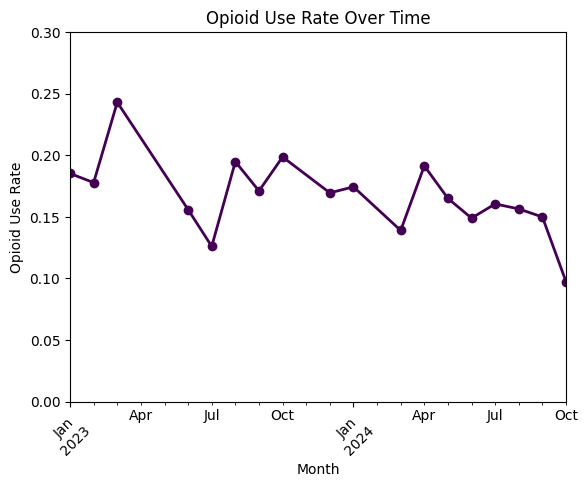

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

# Group data

category_to_keep = "no"  # Change this to the desired category

# Filter DataFrame before grouping
df_filtered = df[df["opioid_use"] == category_to_keep]

sentiment_counts = df_filtered.groupby(["year_month", "opioid_use"]).size().unstack()
sentiment_counts_s = df.groupby(["year_month", "opioid_use"]).size().unstack()

total_category = sentiment_counts.sum(axis=1)
total_comments = sentiment_counts_s.sum(axis=1)

# Set threshold
threshold = 3

# Filter months with enough comments
valid_months = total_category[total_comments >= threshold].index
filtered_sentiment_counts = sentiment_counts.loc[valid_months]

# Compute sentiment rate
sentiment_rate = filtered_sentiment_counts.div(total_comments[valid_months], axis=0)

# Plot
plt.figure(figsize=(12, 6))
sentiment_rate.plot(kind="line", marker="o", colormap="viridis", linewidth=2)

plt.xlabel("Month")
plt.ylabel("Opioid Use Rate")
plt.title("Opioid Use Rate Over Time")
plt.legend().remove() 
plt.xticks(rotation=45)
plt.ylim(0, 0.3)  # Since it's a percentage
plt.show()

<Figure size 1200x600 with 0 Axes>

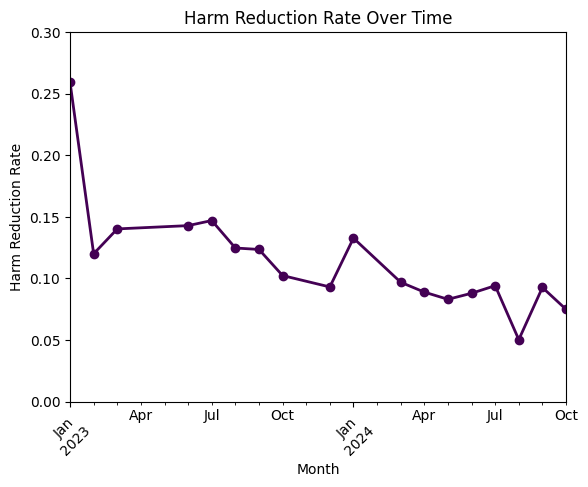

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns


category_to_keep = "no"  

# Filter DataFrame before grouping
df_filtered = df[df["harm_reduction"] == category_to_keep]

sentiment_counts = df_filtered.groupby(["year_month", "harm_reduction"]).size().unstack()
sentiment_counts_s = df.groupby(["year_month", "harm_reduction"]).size().unstack()

total_category = sentiment_counts.sum(axis=1)
total_comments = sentiment_counts_s.sum(axis=1)

# Set threshold
threshold = 4

# Filter months with enough comments
valid_months = total_category[total_category >= threshold].index
filtered_sentiment_counts = sentiment_counts.loc[valid_months]

# Compute sentiment rate
sentiment_rate = filtered_sentiment_counts.div(total_comments[valid_months], axis=0)

# Plot
plt.figure(figsize=(12, 6))
sentiment_rate.plot(kind="line", marker="o", colormap="viridis", linewidth=2)

plt.xlabel("Month")
plt.ylabel("Harm Reduction Rate")
plt.title("Harm Reduction Rate Over Time")
plt.legend().remove() 
plt.xticks(rotation=45)
plt.ylim(0, 0.3) 
plt.show()